# Interaction and coordination modelling

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import src.visualise.visualise_utils as vutils
from src import utils
from src.features.features_utils import PhaseCorrection, GrangerCausality, CrossCorrelation
from src.features.simulations_utils import *
from src.visualise.coordination_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load in data
We need to unserialise our list of onsets first

In [2]:
onsets: list = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

## Create models for each track

In [3]:
models = []
# Iterate over every track
for track in onsets:
    summary_dict = pd.DataFrame(track.summary_dict)
    # Iterate over every instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Subset to get my onsets and partner onsets as separate dataframes
        mine = summary_dict[instr]
        theirs = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
        # Create models - phase correction, granger causality, cross correlation
        model = PhaseCorrection(my_beats=mine, their_beats=theirs, order=1)
        gc = GrangerCausality(my_beats=mine, their_beats=theirs, order=1)
        cc = CrossCorrelation(my_beats=mine, their_beats=theirs, order=1)
        # Append track metadata and summary data from each model type
        models.append(track.item | model.summary_dict | dict(instrument=instr) | gc.summary_dict | cc.summary_dict)
df = pd.DataFrame(models)

In [4]:
# Clean to remove models with fewer than 30 observations
clean = df[df['nobs'] >= 30]

In [5]:
# Get the total number of rows (= total number of models)
clean.shape

(606, 58)

## Get mean self coupling and intercepts

In [6]:
clean.groupby('instrument')[['self_coupling', 'intercept', 'rsquared_adj']].mean()

,self_coupling,intercept,rsquared_adj
instrument,,,
bass,-0.563680,0.001848,0.578296
drums,-0.663284,-0.003946,0.634962
piano,-0.495533,0.019172,0.662729


## Bootstrap mean R<sup>2</sup>

In [7]:
avg_bandleader = clean.groupby(['pianist', 'instrument'])['rsquared_adj'].mean().reset_index(drop=False)
for idx, grp in avg_bandleader.groupby('instrument'):
    vals = grp['rsquared_adj']
    boots = [vals.sample(frac=1, replace=True, random_state=i).mean() for i in range(vutils.N_BOOT)]
    print(idx, np.percentile(boots, 2.5), vals.mean(), np.percentile(boots, 97.5))

bass 0.5578743723114122 0.5764185944952449 0.5946614712271348
drums 0.6017379056517292 0.6297688784886455 0.6585219848062904
piano 0.6326349595378333 0.6626340258731485 0.690934618487538


In [8]:
vals = avg_bandleader['rsquared_adj']
boots = [vals.sample(frac=1, replace=True, random_state=i).mean() for i in range(vutils.N_BOOT)]
print('total', np.percentile(boots, 2.5), vals.mean(), np.percentile(boots, 97.5))

total 0.6033756564848044 0.622940499619013 0.6426220368987516


## Get mean coupling coefficients

In [10]:
cc = clean[['coupling_piano', 'coupling_bass', 'coupling_drums']].values
cc = pd.Series(cc[~np.isnan(cc)])
boots = [cc.sample(frac=1, replace=True, random_state=i).mean() for i in range(10000)]
print(np.percentile(boots, 2.5), cc.mean(), np.percentile(boots, 97.5))

0.3508541118034157 0.3679530181397353 0.3853078780147092


## Get sum of coupling for an instrument

In [19]:
clean[clean['coupling_piano'] < 0]

,track_name,album_name,recording_year,pianist,channel_overrides,mbz_id,notes,time_signature,first_downbeat,rating_bass_audio,rating_bass_detection,rating_drums_audio,rating_drums_detection,rating_mix,rating_piano_audio,rating_piano_detection,rating_comments,has_annotations,links,excerpt_duration,timestamps,log,musicians,photos,fname,phase_correction_order,phase_correction_lag,coupling_piano,coupling_bass,coupling_drums,self_coupling,intercept,resid_std,resid_len,nobs,rsquared,rsquared_adj,aic,bic,llf,instrument,granger_causality_order,granger_causality_piano_i,granger_causality_piano_p,granger_causality_bass_i,granger_causality_bass_p,granger_causality_drums_i,granger_causality_drums_p,cross_corr_order,cross_corr_piano_r,cross_corr_piano_p,cross_corr_piano_n,cross_corr_bass_r,cross_corr_bass_p,cross_corr_bass_n,cross_corr_drums_r,cross_corr_drums_p,cross_corr_drums_n
23,Mr Gentle and Mr Cool,McCoy Tyner plays Ellington,1964,McCoy Tyner,{},0ea667bc-a931-439d-adfa-79062ad167d8,,4,15.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,03:07,"{'start': '01:02', 'end': '04:09'}",[],"{'pianist': 'McCoy Tyner', 'bassist': 'Jimmy G...","{'musicians': {'pianist': None, 'bassist': Non...",tynerm-mrgentleandmrcool-garrisonjjonese-1964-...,1,0,-0.097238,0.382006,NaN,-0.900710,-0.004135,0.041341,90.0,90.0,0.580046,0.565396,-310.055321,-300.056083,159.027661,drums,1,0.260919,8.770762e-15,0.175730,1.958909e-10,NaN,NaN,1,0.276758,0.000106,191.0,0.336042,3.591810e-05,145.0,NaN,NaN,NaN
52,Giant Steps,Remembering John,1991,McCoy Tyner,{},e37a49fc-ca7c-4c21-be09-38e1f979b8cf,,4,16.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,01:16,"{'start': '07:28', 'end': '08:44'}",[],"{'pianist': 'McCoy Tyner', 'bassist': 'Avery S...","{'musicians': {'pianist': None, 'bassist': Non...",tynerm-giantsteps-sharpeascotta-1991-e37a49fc,1,0,-0.014716,NaN,0.165724,-0.566654,0.006029,0.021031,51.0,51.0,0.557032,0.528757,-241.168189,-233.440886,124.584094,bass,1,-0.099120,1.000000e+00,NaN,NaN,0.375184,2.694751e-07,1,0.273777,0.014629,79.0,NaN,NaN,NaN,0.310081,4.582116e-03,82.0
89,Crescent,Live at Sweet Basil,1989,McCoy Tyner,{},e0091f6e-a6d3-4ccb-93b9-82d53844e547,,4,18.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,03:56,"{'start': '01:24', 'end': '05:20'}",[],"{'pianist': 'McCoy Tyner', 'bassist': 'Avery S...","{'musicians': {'pianist': None, 'bassist': Non...",tynerm-crescent-sharpeascotta-1989-e0091f6e,1,0,-0.130667,0.825938,NaN,-0.617293,0.010121,0.029939,33.0,33.0,0.701484,0.670603,-129.918001,-123.931971,68.959001,drums,1,0.012837,1.904940e-01,0.626529,1.110223e-16,NaN,NaN,1,0.373884,0.000073,107.0,0.567725,1.460668e-08,85.0,NaN,NaN,NaN
104,Green Chimneys,Green Chimneys,1984,Kenny Barron,{'piano': 'r'},079c686e-9916-4665-9c02-07546f33052e,,4,9.74,1.0,2.0,3.0,3.0,3.0,3.0,2.0,NaN,False,{'external': ['https://www.youtube.com/watch?v...,02:36,"{'start': '00:42', 'end': '03:18'}",[],"{'pianist': 'Kenny Barron', 'bassist': 'Buster...","{'musicians': {'pianist': None, 'bassist': Non...",barronk-greenchimneys-williamsbrileyb-1984-079...,1,0,-0.021369,0.393294,NaN,-0.606573,-0.002631,0.011916,75.0,75.0,0.514501,0.493987,-443.644648,-434.374696,225.822324,drums,1,-0.051615,1.000000e+00,0.291389,1.110223e-16,NaN,NaN,1,0.155211,0.027798,201.0,0.364396,1.632256e-07,195.0,NaN,NaN,NaN
107,The Only One,The Only One,1990,Kenny Barron,{},724c953d-efbe-42e5-a5d0-9111cbbd8074,,4,7.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,02:33,"{'start': '01:22', 'end': '03:55'}",[],"{'pianist': 'Kenny Barron', 'bassist': 'Ray Dr...","{'musicians': {'pianist': None, 'bassist': Non...",barronk-theonlyone-drummondrrileyb-1990-724c953d,1,0,-0.016249,0.266449,NaN,-0.671304,-0.002189,0.014655,157.0,157.0,0.612385,0.604785,-872.461661,-860.236678,440.230831,drums,1,0.061539,6.083426e-06,0.135862,1.801825e-11,NaN,NaN,1,0.069063,0

In [15]:
influence_df = (
    clean.groupby('mbz_id')
    .agg(dict(
        coupling_piano='sum',
        coupling_bass='sum',
        coupling_drums='sum')
    )
    .reset_index(drop=False)
)
print('piano influence', influence_df['coupling_piano'].mean())
print('bass influence', influence_df['coupling_bass'].mean())
print('drums influence', influence_df['coupling_drums'].mean())

piano influence 0.2514436214950099
bass influence 0.634112010098015
drums influence 0.9803818495172648


## Create triangle plot of mean coupling coefficients

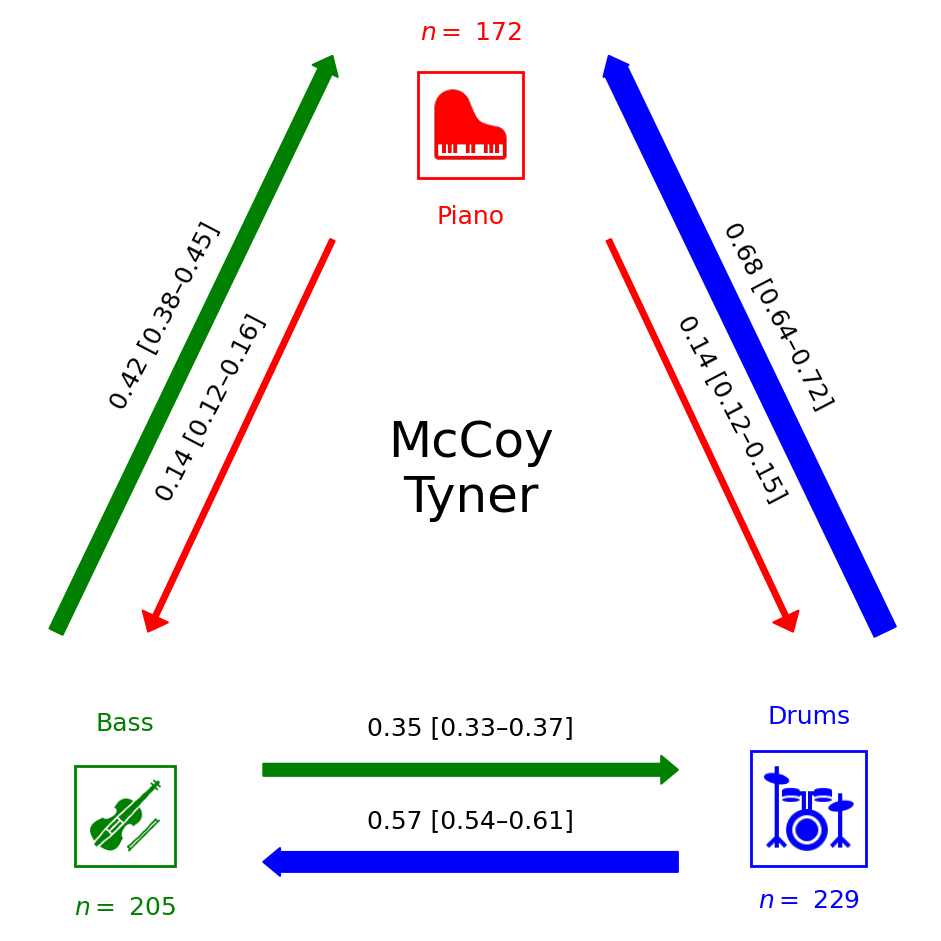

In [24]:
class TriangleWrapper(vutils.BasePlot):
    def __init__(self, model_df, **kwargs):
        self.corpus_title = kwargs.get('corpus_title', 'corpus_chronology')
        super().__init__(figure_title=fr'coordination_plots\triangleplot_alltrios_{self.corpus_title}', **kwargs)
        self.df = model_df.copy(deep=True)
        self.df.loc['pianist', :] = ''
        self.df['performer'] = ''
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))

    def _create_plot(self):
        TriangleAxis(self.df, self.ax).create_plot()

    def _format_fig(self):
        self.fig.subplots_adjust(top=0.99, bottom=0.01, left=0.01, right=0.99)

TriangleWrapper(clean).create_plot()
plt.show()

## Create bar plot of coupling coefficients

C:\Users\huwch\AppData\Local\Temp\ipykernel_748\402493381.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.stripplot(data=self.df.groupby('variable').mean().reset_index(drop=False), x='variable', y='value', s=10, color='#8ffbfd', marker='s', zorder=10)


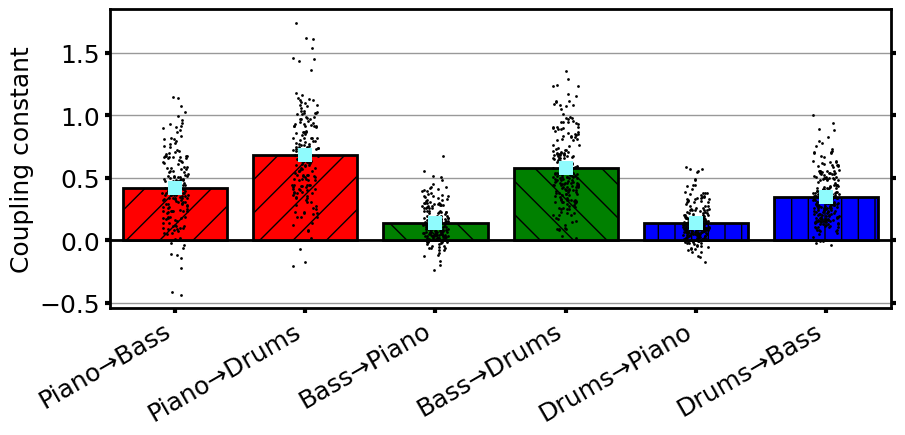

In [22]:
BarPlotCouplingCoefficients(clean).create_plot()
plt.show()

## Control analyses

### Compare coupling across 1st/2nd half of a track

In [3]:
partial_models = []
# Iterate over every track
for track in onsets:
    summary_dict = pd.DataFrame(track.summary_dict)
    # Get the duration of the track
    duration = np.ceil(summary_dict['beats'].max())
    # Get the timestamps for the start and end of the first and second half
    first_half_range = 0, np.ceil(duration / 2)
    second_half_range = first_half_range[1], duration
    # Get the data for the first and second half using hte timestamps
    first_half = summary_dict[(first_half_range[0] <= summary_dict['beats']) & (summary_dict['beats'] <= first_half_range[1])]
    second_half = summary_dict[(second_half_range[0] <= summary_dict['beats']) & (summary_dict['beats'] <= second_half_range[1])]
    # Iterate over each half separately
    for data, half in zip([first_half, second_half], [1, 2]):
        # Create the model for each instrument from the data for each half
        for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
            mine = data[instr]
            theirs = data[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
            partial_model = PhaseCorrection(my_beats=mine, their_beats=theirs)
            # Append the model results, plus some additional metadata
            partial_models.append(track.item | partial_model.summary_dict | dict(instrument=instr, half=half))
partial_df = pd.DataFrame(partial_models)

In [4]:
# Get the minimum number of observations for a half, per instrument and track
small = (partial_df.groupby(['mbz_id', 'instrument'])['nobs'].min() >= 30).reset_index(drop=False)
checker = {}
# Iterate through the rows of the dataframe of acceptable/non-acceptable tracks
for idx, row in small[small['nobs']][['mbz_id', 'instrument']].iterrows():
    # If this row and instrument is acceptable, add the mbz_id as a dictionary key and the instrument to a list (value)
    if row['mbz_id'] not in checker.keys():
        checker[row['mbz_id']] = [row['instrument']]
    else:
        checker[row['mbz_id']].append(row['instrument'])

In [5]:
# Get the acceptable rows in the full dataframe based on our dictionary of lists
is_ok = [row for _, row in partial_df.iterrows() if row['mbz_id'] in checker.keys() and row['instrument'] in checker[row['mbz_id']]]

In [31]:
# Combine the acceptable rows into one dataframe and pivot to get coupling responses as their own column
melt = (
    pd.DataFrame(is_ok)
    .melt(id_vars=['mbz_id', 'half'], value_vars=['coupling_piano', 'coupling_drums', 'coupling_bass', 'half'])
    .dropna()
    .pivot_table(values='value', index=['mbz_id', 'variable'], columns='half')
    .reset_index(drop=False)
    .rename(columns={1: 'half_1', 2: 'half_2'})
)
melt['variable'] = melt['variable'].str.replace('coupling_', '')

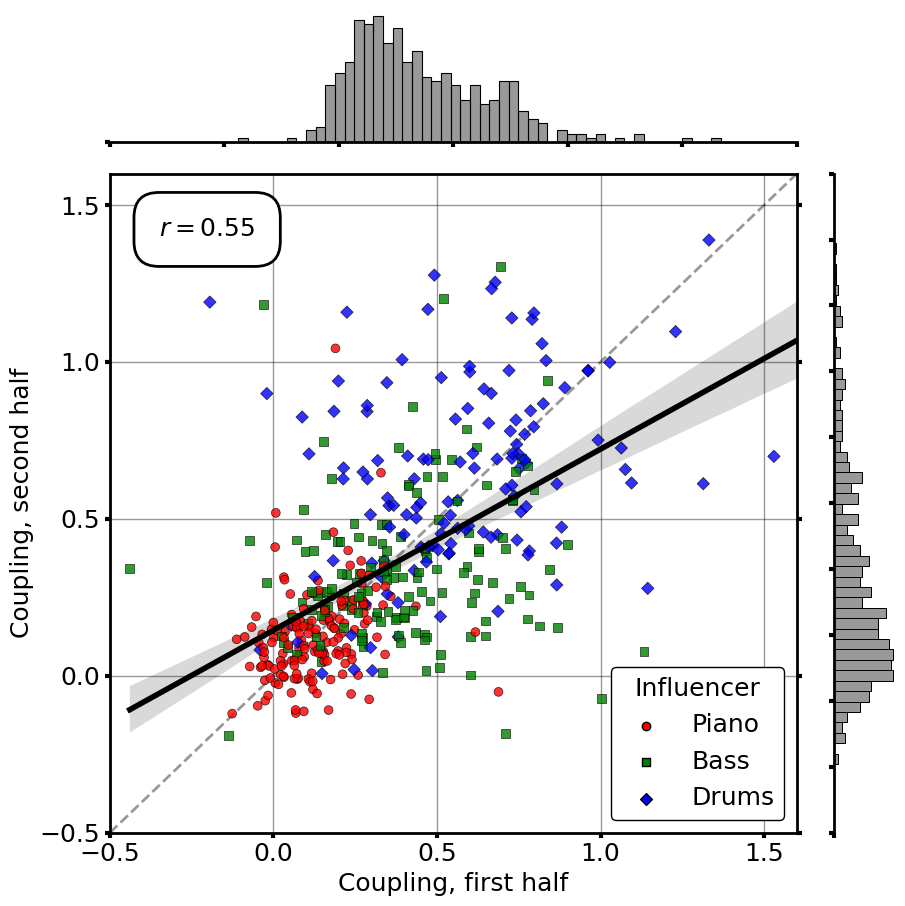

In [69]:
RegPlotCouplingHalves(melt).create_plot()
plt.show()

### Compare coupling, granger causality, and cross-correlation

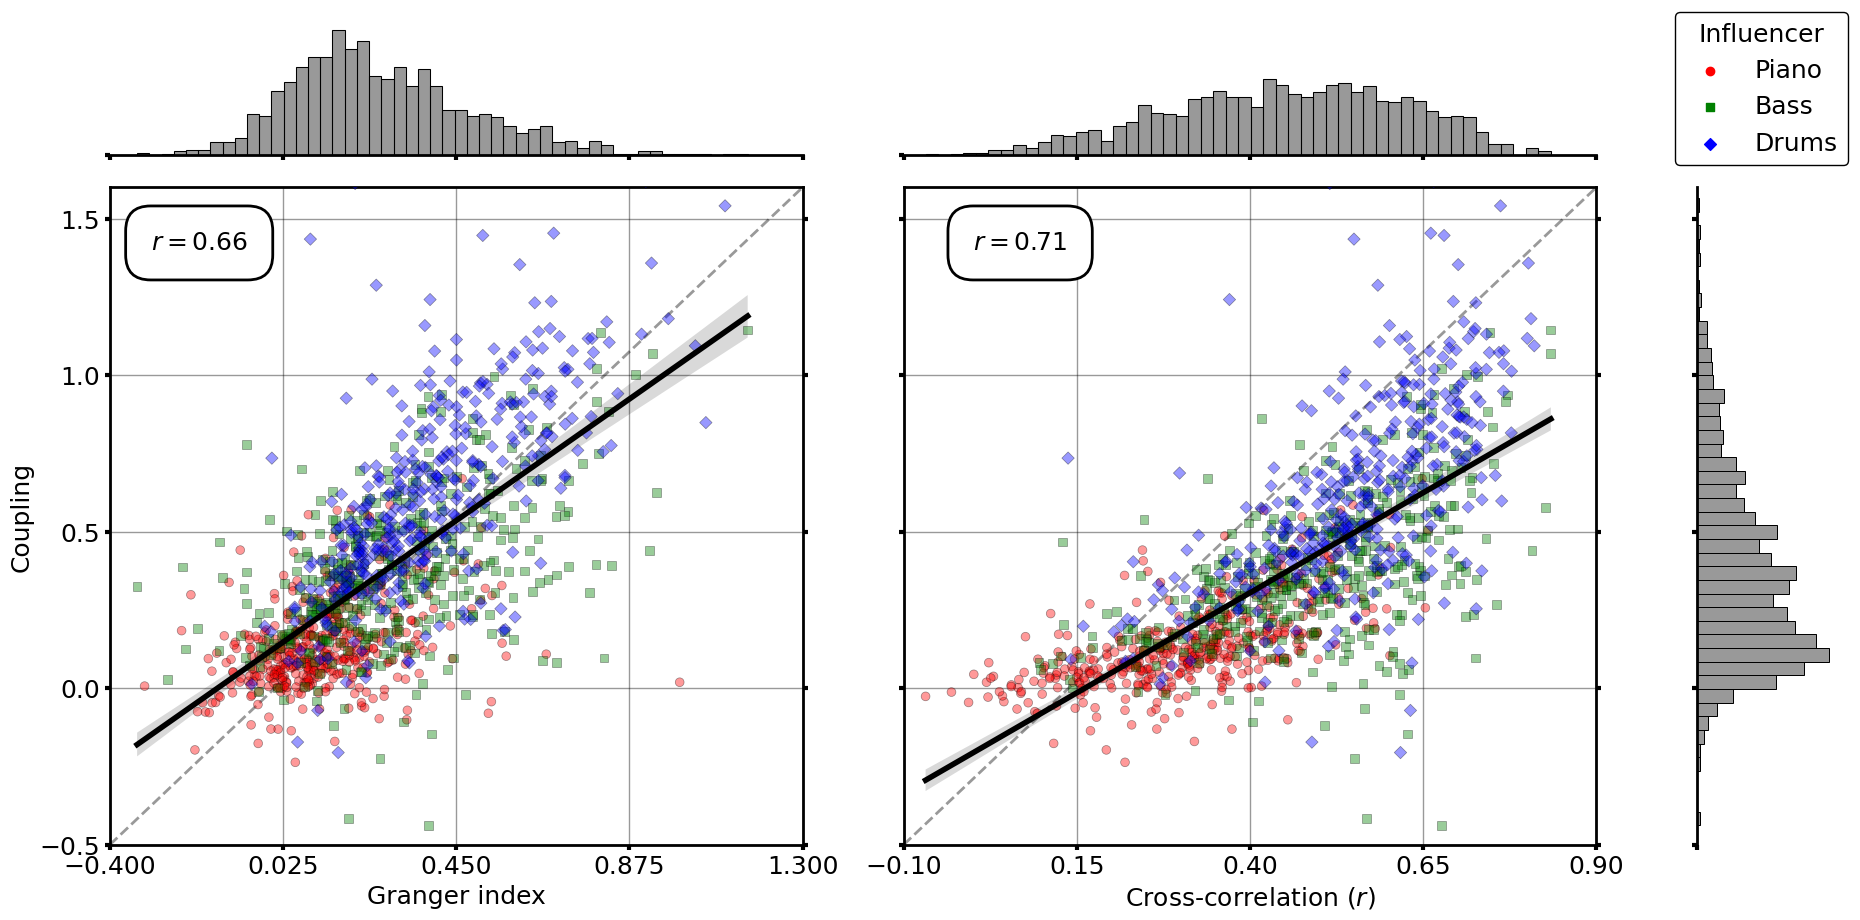

In [90]:
RegPlotCouplingGrangerCross(clean).create_plot()
plt.show()

### Compare higher-order models

## Simulations: individual strategies

### Get parameters for simulations

In [12]:
cols = ['self_coupling', 'coupling_piano', 'coupling_bass', 'coupling_drums', 'resid_std', 'intercept']
params = (
    clean.groupby('instrument')
    [cols]
    .mean()
    .to_dict(orient='index')
)

In [13]:
# Get mean parameters from our original parameters
mean_coupling = np.nanmean(clean[['coupling_piano', 'coupling_drums', 'coupling_bass']].values.flatten())
mean_self_coupling = np.nanmean(clean['self_coupling'].values)
mean_intercept = np.nanmean(clean['intercept'].values)
noise_constant = 0.005

### Create simulations using original coupling parameters

In [39]:
original_params = {
    'piano': {
        **params['piano'],
        'resid_std': noise_constant,
    },
    'bass': {
        **params['bass'],
        'resid_std': noise_constant,
    },
    'drums': {
        **params['drums'],
        'resid_std': noise_constant,
    },
}

In [40]:
original = SimulationManager(original_params, tempo=120, n_sims=500)
original.run_simulations()
original.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.4s finished


0.014030797603798389

### Create democracy simulations

In [15]:
balanced_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': mean_coupling,
        'coupling_drums': mean_coupling,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': mean_intercept,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': mean_coupling,
        'coupling_drums': mean_coupling,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': mean_intercept,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': mean_coupling,
        'coupling_bass': mean_coupling,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': mean_intercept,
    }
}

In [16]:
balanced = SimulationManager(balanced_params, tempo=120, n_sims=500)
balanced.run_simulations()
balanced.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.8s finished


0.0030551355886849715

### Create anarchy simulations

In [17]:
no_coupling_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': 0,
        'coupling_drums': 0,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
        'resid_std': noise_constant
    },
    'bass': {
        **params['bass'],
        'coupling_piano': 0,
        'coupling_drums': 0,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
        'resid_std': noise_constant
    },
    'drums': {
        **params['drums'],
        'coupling_piano': 0,
        'coupling_bass': 0,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
        'resid_std': noise_constant
    }
}

In [18]:
no_coupling = SimulationManager(no_coupling_params, tempo=120, n_sims=500)
no_coupling.run_simulations()
no_coupling.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   11.4s finished


0.855500261274015

### Create drummer-leader simulations

In [32]:
drums_leader_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': 0,
        'coupling_drums': mean_coupling,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': 0,
        'coupling_drums': mean_coupling,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': 0,
        'coupling_bass': 0,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
    }
}

In [33]:
drums_leader = SimulationManager(drums_leader_params, tempo=120, n_sims=500)
drums_leader.run_simulations()
drums_leader.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.8s finished


0.00912107122592041

### Create bass leader simulations

In [34]:
bass_leader_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': mean_coupling,
        'coupling_drums': 0,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': 0,
        'coupling_drums': 0,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': 0,
        'coupling_bass': mean_coupling,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
    }
}

In [35]:
bass_leader = SimulationManager(bass_leader_params, tempo=120, n_sims=500)
bass_leader.run_simulations()
bass_leader.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.6s finished


0.00892542252573191

### Create piano leader simulations

In [36]:
piano_leader_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': 0,
        'coupling_drums': 0,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': mean_coupling,
        'coupling_drums': 0,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': mean_coupling,
        'coupling_bass': 0,
        'self_coupling': -abs(mean_self_coupling),
        'intercept': 0,
    }
}

In [37]:
piano_leader = SimulationManager(piano_leader_params, tempo=120, n_sims=500)
piano_leader.run_simulations()
piano_leader.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.7s finished


0.009442763787049287

### Plot proportional RMS

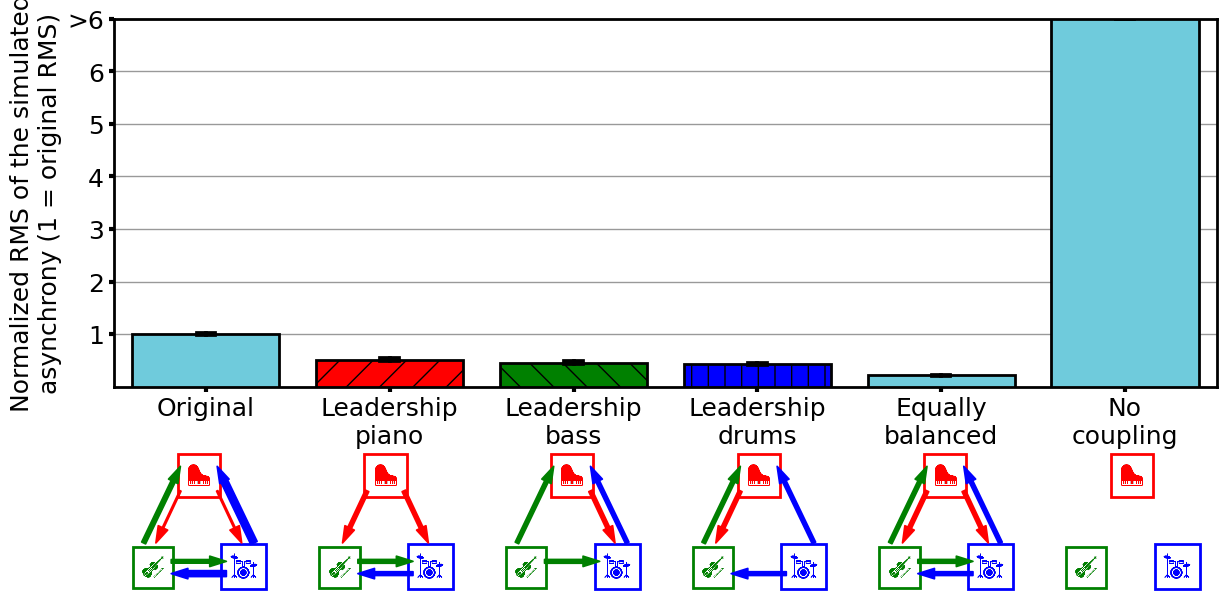

In [25]:
BarPlotSimulationComparison(
    all_sims=[original, piano_leader, bass_leader, drums_leader, balanced, no_coupling],
    all_params=[params, piano_leader_params, bass_leader_params, drums_leader_params, balanced_params, no_coupling_params]
).create_plot()

## Simulations: parameter space

In [185]:
for i in range(10):
    current = {
        'piano': {
            **params['piano'],
            'coupling_bass': np.linspace(params['piano']['coupling_bass'], params['piano']['coupling_bass'] + 1, 10)[i],
            'coupling_drums': np.linspace(params['piano']['coupling_drums'], params['piano']['coupling_drums'] + 1, 10)[i],
        },
        'bass': {
            **params['bass'],
            'coupling_piano': np.linspace(params['bass']['coupling_piano'], params['bass']['coupling_piano'] + 1, 10)[i],
            'coupling_drums': np.linspace(params['bass']['coupling_drums'], params['bass']['coupling_drums'] + 1, 10)[i],
        },
        'drums': {
            **params['drums'],
            'coupling_piano': np.linspace(params['drums']['coupling_piano'], params['drums']['coupling_piano'] + 1, 10)[i],
            'coupling_bass': np.linspace(params['drums']['coupling_bass'], params['drums']['coupling_bass'] + 1, 10)[i],
        }
    }
    current_sims = SimulationManager(current, tempo=120, n_sims=500)
    current_sims.run_simulations()
    print(i, current_sims.get_mean_rms())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.8s finished


0 0.014175690108046295


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.5s finished


1 0.011384209467773706


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.7s finished


2 0.003034237880515966


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.0s finished


3 0.002555310557348288


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.2s finished


4 0.002512588584117866


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.1s finished


5 0.002566223213018288


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.1s finished


6 0.0026651434149194283


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.6s finished


7 0.0027432275197033012


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.6s finished


8 0.0027992636311279105


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.3s


9 0.002911005940296605


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.1s finished


In [182]:
for i in range(10):
    # current = {
    #     'piano': {
    #         **params['piano'],
    #         'coupling_bass': np.linspace(0, params['piano']['coupling_bass'], 10)[i],
    #         'coupling_drums': np.linspace(0, params['piano']['coupling_drums'], 10)[i],
    #     },
    #     'bass': {
    #         **params['bass'],
    #         'coupling_piano': np.linspace(0, params['bass']['coupling_piano'], 10)[i],
    #         'coupling_drums': np.linspace(0, params['bass']['coupling_drums'], 10)[i],
    #     },
    #     'drums': {
    #         **params['drums'],
    #         'coupling_piano': np.linspace(0, params['drums']['coupling_piano'], 10)[i],
    #         'coupling_bass': np.linspace(0, params['drums']['coupling_bass'], 10)[i],
    #     }
    # }
    print(np.linspace(params['piano']['coupling_bass'], mean_coupling, 10)[i])

0.4178927218632842
0.376387109900446
0.3348814979376078
0.2933758859747696
0.2518702740119314
0.21036466204909324
0.16885905008625507
0.12735343812341687
0.08584782616057868
0.0443422141977405


In [183]:
mean_coupling

0.0443422141977405